In [1]:
import os, sys, PIL, time, cv2, random
import numpy as np
np.random.seed(1234)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from tqdm import tqdm

import tensorflow as tf
import keras
from keras import backend as K
print 'keras backend: ', K._BACKEND
print 'keras version: ', keras.__version__
print 'tensorflow version: ', tf.__version__

sess = tf.Session()
K.set_session(sess)
# fix input size in model for tensorflow
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


keras backend:  tensorflow
keras version:  2.0.0
tensorflow version:  1.0.1


Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [3]:
DATAFOLDER = '%s/Documents/DogsCats/' %(os.path.expanduser('~'))
WIDTH = 64
HEIGHT = 64
CHANNELS = 3

train_images = [DATAFOLDER+'train/'+i for i in os.listdir(DATAFOLDER+'train/')]
test_images = [DATAFOLDER+'test/'+i for i in os.listdir(DATAFOLDER+'test/')]
train_dogs = [DATAFOLDER+'train/'+i for i in os.listdir(DATAFOLDER+'train/') if 'dog' in i]
train_cats = [DATAFOLDER+'train/'+i for i in os.listdir(DATAFOLDER+'train/') if 'cat' in i]

train_images = train_dogs[:5000] + train_cats[:5000]
random.shuffle(train_images)
#test_images = test_images[:25]


def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)

def prepare_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, WIDTH, HEIGHT), dtype=np.float32)
    print ''
    for i, img_file in enumerate(tqdm(images)):
        img = read_image(img_file)
        data[i] = img.T / 255.0
        #if i%1000 == 0:
        #    print 'Processed %d of %d images' %(i, count)
    return data

print 'Loading train data'
Xtrain = prepare_data(train_images)
print 'Loading test data'
Xtest = prepare_data(test_images)

print 'Xtrain shape:', Xtrain.shape
print 'Xtest shape:',  Xtest.shape

  0%|          | 44/10000 [00:00<00:22, 439.39it/s]

Loading train data



  0%|          | 53/12500 [00:00<00:23, 523.08it/s]

Loading test data



Xtrain shape: (10000, 3, 64, 64)
Xtest shape: (12500, 3, 64, 64)


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


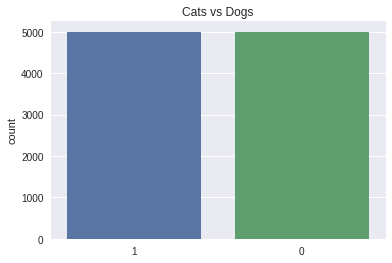

In [4]:
ytrain = []
for i in train_images:
    if ('dog' in i):
        ytrain.append(1)
    else:
        ytrain.append(0)
sns.countplot(ytrain)
sns.plt.title('Cats vs Dogs')

In [5]:
def cnn():
    model = Sequential()
    
    model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(CHANNELS, WIDTH, HEIGHT), activation='relu'))
    model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
    
    model.summary()
    return model

In [6]:
model = cnn()

/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(3, 64, 64...)`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 64, 64)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 64, 64)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 32, 32)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 16, 16)        0         
__________

In [7]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batcj, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def run_cnn(Xtrain, ytrain, epochs=1):
    history = model.fit(Xtrain, ytrain, batch_size=64, epochs=epochs, validation_split=0.1)
    #history = model.fit(Xtrain, ytrain, batch_size=64, epochs=epochs, validation_split=0.2, 
    #          callbacks=[EarlyStopping(monitor='val_losses', patience=0, verbose=1)])
    #ypred = model.predict(Xtest)
    return history

def run_pred(Xtest):
    return model.predict(Xtest, verbose=1)


In [8]:

ytraincategorical = np_utils.to_categorical(ytrain)
history = run_cnn(Xtrain, ytrain, epochs=10)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 517s - loss: 0.7274 - acc: 0.4943 - val_loss: 0.6900 - val_acc: 0.5250
Epoch 2/10
9000/9000 [==============================] - 526s - loss: 0.6984 - acc: 0.5620 - val_loss: 0.6708 - val_acc: 0.5850
Epoch 3/10
9000/9000 [==============================] - 516s - loss: 0.6606 - acc: 0.6136 - val_loss: 0.6499 - val_acc: 0.6280
Epoch 4/10
9000/9000 [==============================] - 549s - loss: 0.6133 - acc: 0.6729 - val_loss: 0.5906 - val_acc: 0.6860
Epoch 5/10
9000/9000 [==============================] - 473s - loss: 0.5715 - acc: 0.7082 - val_loss: 0.5770 - val_acc: 0.6820
Epoch 6/10
9000/9000 [==============================] - 440s - loss: 0.5327 - acc: 0.7371 - val_loss: 0.5238 - val_acc: 0.7450
Epoch 7/10
9000/9000 [==============================] - 441s - loss: 0.5054 - acc: 0.7570 - val_loss: 0.5290 - val_acc: 0.7490
Epoch 8/10
9000/9000 [==============================] - 444s - 

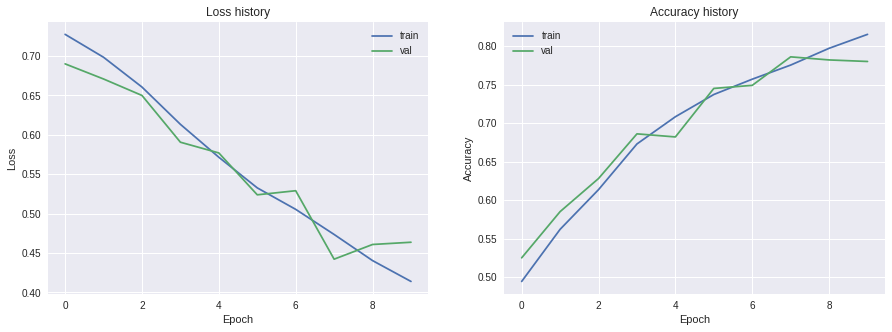

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
#plt.yscale('log')
ax[0].set_title('Loss history')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['acc'], label='train')
ax[1].plot(history.history['val_acc'], label='val')
#plt.yscale('log')
ax[1].set_title('Accuracy history')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
plt.show()

In [10]:
ypred = run_pred(Xtest)
print ypred[:10]
with open('submission.csv', 'w') as f:
    f.write('id,label\n')
    for i in tqdm(range(len(ypred))):
        f.write('%d,%f\n' %(i+1, ypred[[i]]))

12500/12500 [==============================] - 285s   


[[ 0.02606579]
 [ 0.25272709]
 [ 0.84506834]
 [ 0.06816132]
 [ 0.08418647]
 [ 0.19521561]
 [ 0.7127732 ]
 [ 0.44752935]
 [ 0.94788802]
 [ 0.12210202]]
